<h3> Imports </h3>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from sklearn.impute import SimpleImputer
import category_encoders as ce
import matplotlib.pyplot as plt
import fitter
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.nc import QuantileRegErrFunc
from nonconformist.nc import QuantileRegAsymmetricErrFunc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from nonconformist.nc import RegressorNormalizer
from nonconformist.nc import AbsErrorErrFunc
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

np.warnings.filterwarnings('ignore')

# !pip install torch
# !pip install Scikit-garden
# !pip install --upgrade scikit-learn==0.20.3
# !pip install Scikit-garden
# !pip install --upgrade scikit-learn==0.20.3

<h3> Helper Methods </h3>

In [2]:
## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

#binary encode columns in dataset
def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df

#split the data to training and testing according to special split based on Site
def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)

    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

#get grid of all hyper-parameters
def get_param_grid(dicts):
    return [dict(zip(dicts.keys(), p)) for p in it.product(*dicts.values())]


#density plot for any array
def plot_density(array, title, variable_name):
    ''' produces a density plot of a given variable '''
    sns.distplot(array, hist=False, kde=True,
                 kde_kws={'linewidth': 3},
                 label=variable_name).set(title=title, xlabel=variable_name, ylabel='density')
    plt.show()
    plt.close()
    
    
#preprocess the dataset: remove columns, filter nans, etc
def GetDataset(name, base_path):
    if name=="library":
        
        #Library
        output_column = 'LE_bowen_corr_mm'
        columnsToDrop = ['Year','Month','Day','Latitude','Longitude',
                         'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                         'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                         'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                         'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                         'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                         'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                         'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                         'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                         'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                         'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                         'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                         'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                         'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
                         'Site_6', 'ET_bowen_corr_mm', 'ETo'
                         ]  
        
        df=pd.read_csv(base_path)
        #set output variable between 1 and 15 only
        df = df[df[output_column].between(1, 15)]
        #df.rename(columns_rename, inplace=True)

        #drop desired columns, rename, and drop the nans
        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        #generate lags for columns
        lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
        df = generate_lags(df, lagsForColumns)

        df = binary_encode_column(df, "Site")
        df.drop(columns=['Site_0'], inplace=True)

        #drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
        df.isnull().mean() * 10
        df.dropna(inplace=True)
        print(df.shape)
        print("checking null values in the whole dataset")
        print(df.isnull().values.any())
        print(df.columns)
        #df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
        #df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
        df.dropna(inplace=True)
        X = df.drop(['LE_bowen_corr_mm', "Date"], axis = 1)
        y = df['LE_bowen_corr_mm']
        
        
        
    if name=="library_reg_split":
        
        #Library
        output_column = 'LE_bowen_corr_mm'
        columnsToDrop = ['Year','Month','Day','Latitude','Longitude',
                         'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                         'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                         'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                         'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                         'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                         'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                         'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                         'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                         'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                         'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                         'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                         'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                         'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
                         'Site_6', 'ET_bowen_corr_mm', 'ETo'
                         ]  
        
        df=pd.read_csv(base_path)
        #set output variable between 1 and 15 only
        df = df[df[output_column].between(1, 15)]
        #df.rename(columns_rename, inplace=True)

        #drop desired columns, rename, and drop the nans
        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        #generate lags for columns
        lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
        df = generate_lags(df, lagsForColumns)

        df = binary_encode_column(df, "Site")
        df.drop(columns=['Site_0'], inplace=True)

        #drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
        df.isnull().mean() * 10
        df.dropna(inplace=True)
        print(df.shape)
        print("checking null values in the whole dataset")
        print(df.isnull().values.any())
        print(df.columns)
        #df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
        #df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
        df.dropna(inplace=True)
        X = df.drop(['LE_bowen_corr_mm', "Date", "Site"], axis = 1)
        y = df['LE_bowen_corr_mm']
        X = X.astype(np.float32)
        y = y.astype(np.float32)


    return X, y, df

<h3> Reading Dataset and Setting Global Variables </h3>

In [3]:
seed = 1

output_column = 'LE_bowen_corr_mm'

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

random_state = 0 

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.2

# desired quanitile levels
quantiles = [0.05, 0.95]

# used to determine the size of test set
test_ratio = 0.2

# name of dataset
dataset_base_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
dataset_name = "library"

# load the dataset
X, y, df = GetDataset(dataset_name, dataset_base_path)


# divide the dataset into test and train based on the test_ratio parameter
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_ratio,
                                                    random_state=random_state_train_test)

columnToDrop = ["Site"]
x_train.drop(columnToDrop, axis = 1, inplace=True)
x_test.drop(columnToDrop, axis = 1, inplace=True)
df.drop(columnToDrop, axis = 1, inplace=True)

# reshape the data
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# compute input dimensions
n_train = x_train.shape[0]
in_shape = x_train.shape[1]

# display basic information
print("Dataset: %s" % (dataset_name))
print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
      (x_train.shape[0], x_train.shape[1], x_test.shape[0], x_test.shape[1]))

(5123, 51)
checking null values in the whole dataset
False
Index(['Date', 'Site', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm',
       'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3',
       'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1',
       'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5',
       'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5', 'Site_1',
       'Site_2', 'Site_3', 'Site_4', 'Site_5'],
      dtype='object')
Dataset: library
Dimensions: train set (n=4098, p=48) ; test set (n=1025, p=48)


<h3> Data Splitting </h3>

In [4]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

# zero mean and unit variance scaling 
scalerX = RobustScaler()
scalerX = scalerX.fit(x_train[idx_train])

# scale
# here, scaling gave better results
x_train = scalerX.transform(x_train)
x_test = scalerX.transform(x_test)

# scale the labels by dividing each by the mean absolute response
mean_y_train = np.mean(np.abs(y_train[idx_train]))
y_train = np.squeeze(y_train)/mean_y_train
y_test = np.squeeze(y_test)/mean_y_train

print("After splitting, this is the size of the training set: " + str(len(y_train)))
print("After splitting, this is the size of the test set: " + str(len(y_test)))

After splitting, this is the size of the training set: 4098
After splitting, this is the size of the test set: 1025


<h3> CQR Random Forest </h3>

In [5]:
#########################################################
#  Quantile random forests parameters
# (See QuantileForestRegressorAdapter class in helper.py)
#########################################################
                # DEFAULT PARAMS
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = x_train.shape[1]

# target quantile levels
quantiles_forest = [quantiles[0]*100, quantiles[1]*100]

# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 0.85

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = 1

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10

In [20]:
# define the QRF's best parameters 
params_qforest = dict()
params_qforest["n_estimators"] = 2000
params_qforest["max_depth"] = 10
params_qforest["min_samples_leaf"] = 1
params_qforest["max_features"] = 'sqrt'
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.85
params_qforest["test_ratio"] = 0.05
params_qforest["random_state"] = 1
params_qforest["range_vals"] = 30
params_qforest["num_vals"] = 20
quantiles_forest = [5.0, 95.0]

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest, cqr_std, distances = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Random Forests")

(2, 1) error dist shape
(1025, 2) prediction dist shape
CQR Random Forests: Percentage in the range (expecting 80.00): 83.024390
CQR Random Forests: Average length: 0.827552
CQR Random Forests: Std length: 0.314870


<h3> Plot the prediction intervals and the original target values </h3>

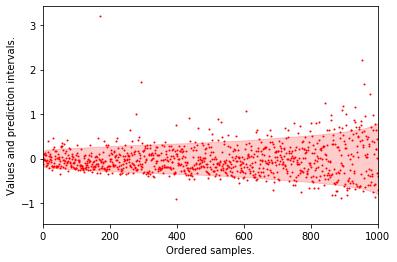

In [21]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

<h3> Plotting Distribution of Lengths of the Ranges </h3>

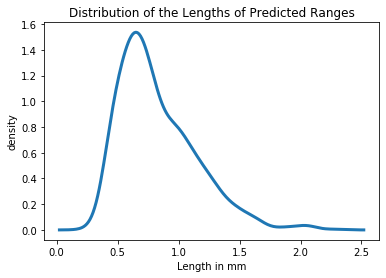

In [22]:
plot_density(np.abs(distances), 'Distribution of the Lengths of Predicted Ranges', "Length in mm")

{'fatiguelife': (0.4626763204351762, 0.1491223061913476, 0.6128438271410085)}

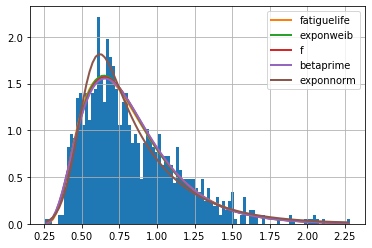

In [23]:
f = fitter.Fitter(np.abs(distances))
f.distributions = f.distributions[0:30] + ['gamma']
f.fit()
f.summary()
f.get_best(method='sumsquare_error')

## Split conformal

In this section we implement the usual split conformal method. Specifically, we use the proper training and calibration subsets; train a random forest regressor on the first set, and calibrate the intervals on the second set by computing the absolute residual error. Notice that the random forests regressor **estimates the conditional mean** of $Y_i$ given $X_i=x$.

In [15]:
# define the conditonal mean estimator as random forests
mean_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       random_state=0)

# define a conformal prediction object 
nc = RegressorNc(mean_estimator, AbsErrorErrFunc())

# build a regualr split conformal prediction object 
icp = IcpRegressor(nc)

# fit the conditional mean regression to the proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute errors on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])
print("This is shape of x calibration " + str(x_train[idx_cal].shape))

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional mean estimation
pred = mean_estimator.predict(x_test)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the interval per each test point
length_split_rf = y_upper - y_lower

# compute and display the average length
print("Random Forests: Average length:", np.mean(length_split_rf))
print("Random Forests: Std length:", np.std(length_split_rf))

This is shape of x calibration (2049, 48)
(2, 1) error dist shape
(1025,) prediction dist shape
Random Forests: Percentage in the range (expecting 80.0%): 82.04878048780488
Random Forests: Average length: 0.794856075861814
Random Forests: Std length: 6.857039888148152e-17


<h3> Plot the prediction intervals and the original target values </h3>

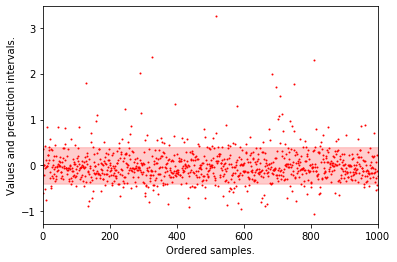

In [16]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

<h3> Plotting Distribution of Lengths of the Ranges </h3>

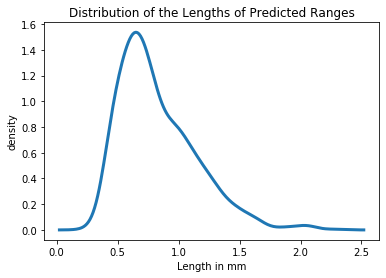

In [17]:
plot_density(np.abs(distances), 'Distribution of the Lengths of Predicted Ranges', "Length in mm")

{'fatiguelife': (0.4626763204351762, 0.1491223061913476, 0.6128438271410085)}

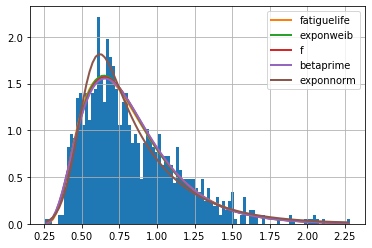

In [18]:
f = fitter.Fitter(np.abs(distances))
f.distributions = f.distributions[0:30] + ['gamma']
f.fit()
f.summary()
f.get_best(method='sumsquare_error')

As can be seen, the prediction interval constructed by the split conformal achieves valid coverage. Notice that the average length of the constructed interval is greater than the one obtained by CQR.

This experiment reveals a major limitation of the split conformal $-$ the length of the interval constructed by the split conformal is fixed and independent of $X$.

## Local conformal

In this section we implement a well-known variant of the locally weighted split conformal method [3], aiming at constructing adaptive intervals. As in the usual split conformal, this method fits a **conditional mean regression function** to the proper training set (formulated as random forest regressor). In the next step, the locally weighted method fits another (second conditional mean regressor) random forests model to the absolute residuals of the proper training set (MAD estimator), this in order to scale the future test residuals. Just as before, the calibration set is used to construct the conformal interval.

In [10]:
# define the conditonal mean estimator as random forests (used to predict the labels)
mean_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       random_state=random_state)

# define the MAD estimator as random forests (used to scale the absolute residuals)
mad_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      random_state=random_state)

# define a conformal normalizer object that uses the two regression functions.
# The nonconformity score is absolute residual error
normalizer = RegressorNormalizer(mean_estimator,
                                 mad_estimator,
                                 AbsErrorErrFunc())

# define the final local conformal object 
nc = RegressorNc(mean_estimator, AbsErrorErrFunc(), normalizer)

# build the split local conformal object
icp = IcpRegressor(nc)

# fit the conditional mean and MAD models to proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)

# extract the lower and upper bound of the prediction interval
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional mean estimation
pred = mean_estimator.predict(x_test)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Local Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the interval per each test point
length_local_rf = y_upper - y_lower

# compute and display the average length
print("Local Random Forests: Average length:", np.mean(length_local_rf))

(2, 1) error dist shape
(1025,) prediction dist shape
Local Random Forests: Percentage in the range (expecting 80.0%): 100.0
Local Random Forests: Average length: 8.227389439395523


<h3> Plot the prediction intervals and the original target values </h3>

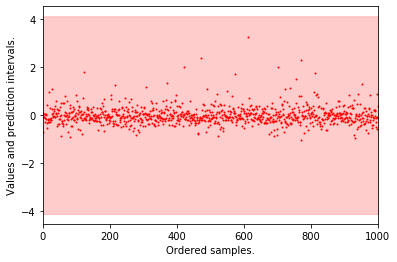

In [12]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

<h3> Plotting Distribution of Lengths of the Ranges </h3>

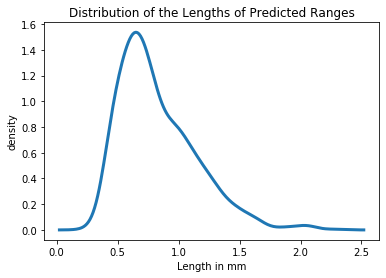

In [13]:
plot_density(np.abs(distances), 'Distribution of the Lengths of Predicted Ranges', "Length in mm")

{'fatiguelife': (0.4626763204351762, 0.1491223061913476, 0.6128438271410085)}

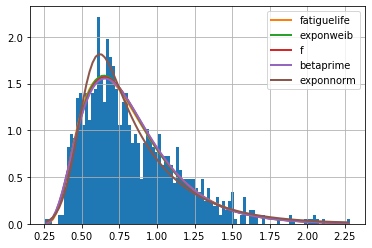

In [14]:
f = fitter.Fitter(np.abs(distances))
f.distributions = f.distributions[0:30] + ['gamma']
f.fit()
f.summary()
f.get_best(method='sumsquare_error')